### Technical Structure 

1. Character Embeddings
2. CNN 
3. Highway Network 
4. RNN 
5. Prediction 



![Screenshot 2023-11-06 190756.png](<attachment:Screenshot 2023-11-06 190756.png>)
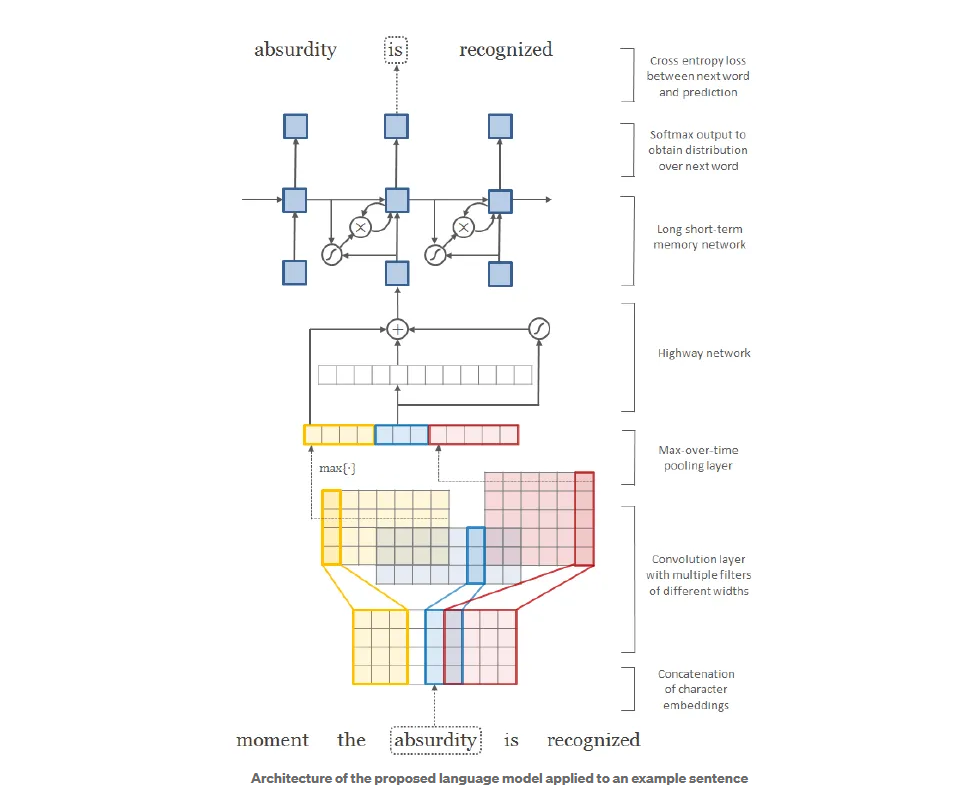

In [ ]:
import numpy as np
import pandas as pd
from pickle import dump
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, SimpleRNN
import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re 
import string 

### Load Input

In [ ]:
def load_doc(filename, lines_to_read=None):
    file = open(filename, 'r')
    amt = lines_to_read
    content = file.readlines()
    if amt:
        content = content[:amt]
    
    # remove any new line characters and make one line of string (this will result in spaces between lines though)
    text = ' '.join([line.strip('\n')  for line in content])
    file.close()
    return text 

In [ ]:
# load text
raw_text = load_doc('data/train.txt', lines_to_read=200)

### Word Encoder

In [ ]:
class WordEncoder:
    def __init__(self, raw_text):
        
        self.oov_word = '<unk>'
        
        # create vocabulary
        raw_text = raw_text.replace(self.oov_word, '') # remove any unwanted tokens (this step just helps prevent <> from being removed from input string and then it being misinterpreted)       

        
        # use tokenizer to get the unique words in raw_text
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts([raw_text])
        self.vocabulary = list(tokenizer.word_index.keys())
        self.vocabulary.append(self.oov_word) # make sure to add the oov word 
        
        # create look up tables
        self.word2int = {word: i for i, word in enumerate(self.vocabulary)} # Mapping from word to its numerical representation
        self.int2word = {index: word for word, index in self.word2int.items()}  # Mapping from numerical representation to word
        
        self.word_embd_dim = len(self.vocabulary)
        
    def get_int_rep(self, word):
        if word.lower() not in self.vocabulary:
            # map 2 unknown if we dont know word
            return self.word2int[self.oov_word]
        else:
            return self.word2int[word.lower()]
    
    

    def encode_text(self, text):
        
        words = text.split()
        
        # Convert the input text into a list of numerical representations
        encoded_text = [self.get_int_rep(word) for word in words]
        
        # One-hot encode if one_hot 
        encoded_text = to_categorical(encoded_text, num_classes=len(self.vocabulary))
        return encoded_text, words 

    def encode_labels(self, labels):
        # Convert labels to one-hot encoding representation
        encoded_labels = [self.get_int_rep(label) for label in labels]
        return to_categorical(encoded_labels, num_classes=len(self.vocabulary))
    
    def decode_text(self, encoded_text):        
        return [ self.int2word[np.argmax(encoded)] for encoded in encoded_text]
        


In [ ]:
word_encoder = WordEncoder(raw_text)
encoded_input, words_encoded = word_encoder.encode_text(raw_text)

### Character Encoder (Takes in list of words and encodes them to some numerical representation)

In [ ]:
class CharacterEncoder(object):

    def __init__(self, max_char):
 
      
        self.vocabulary = list("""ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[] """)
        
        self.char2int = {}  # This will store the mapping from character to its numerical represnetation 
        
        self.char2int['<pad>'] = 0  # this will be the numerical representation of the <pad> token
        self.char2int['{'] = 1  # numerical value of the start of word token
        self.char2int['}'] = 2  # numerical representation of end of word token
        self.char2int['<unk>'] = 3  # this will be the representation of an unknown token
        
        self.curr_id = 4 # start here since we have represnetations for indexes 0-3
        
        # encode all the characters 
        for c in self.vocabulary:
            self.char2int[c] = self.curr_id
            self.curr_id = self.curr_id + 1 
            
            
        # make variables for key embeddings so we know their numerical represnetation 
        self.pad_id = self.char2int['<pad>'] # padding id 
        self.unk_id = self.char2int['<unk>'] # unknown word id 
        self.sow_id = self.char2int["{"] # start of word id 
        self.eow_id = self.char2int["}"] # end of word id 
        
        # Converts embeddings to characters
        self.int2char = {self.char2int[key]: key for key in self.char2int.keys()}  

        
        self.vocabulary_size = len(self.char2int.keys()) # this will include special embeddings too
        self.max_char = max_char
    
    def get_int_rep(self, char):
        if char not in self.vocabulary:
            return self.unk_id
        else:
            return self.char2int[char]
    
    def pad_encoded_sentence(self, sent):
        
        padded_sentence = []
        
        for word in sent:
            new_word = word + ([self.pad_id] * (self.max_char - len(word)))
            padded_sentence.append(new_word)
        
        return padded_sentence 
        
    def encode_words(self, sent, addPadding=True, oneHot=True, columnRep=True):
        """ 
            Convert list of sentences of words into list of list of list of character indices.
            
            
            sent: list of strings
        """
        
        encoded_sent = []
        
        # for this sentence, go through and represent as a list of numerical value  
        for word in sent:
            rep = []    
            
            # mark start of the word 
            #rep.append(self.sow_id) I dont think you do this here
            
            # go through characters in word and embed them  
            for char in word:
                rep.append(self.get_int_rep(char))
            
            # denonate the end of the "word" in this case its a character 
            #rep.append(self.eow_id)  # dont do this here 
            
            encoded_sent.append(rep[:self.max_char])
        
     
        # padd sentence
        if addPadding:
            encoded_sent = self.pad_encoded_sentence(encoded_sent)
        
        # one hot encode 
        if oneHot:
            encoded_sent = to_categorical(encoded_sent, num_classes=self.vocabulary_size)
        
        # for convolution we need to have characters be represented as columns
        if columnRep:
           encoded_sent = np.transpose(encoded_sent, axes=(0, 2, 1))
                
        return encoded_sent
    
    def encode_labels(self, labels):
        # convert labels to one hot encoding representation
        encoded_labels = []
        for label in labels:
            
            # convert characyer to int 
            numerical_rep = self.char2int[label]
            # convert int to one hot 
            one_hot = to_categorical(numerical_rep, num_classes=self.vocabulary_size)
            
            # save it 
            encoded_labels.append(one_hot)

        return np.array(encoded_labels)
    
    def decode_words(self, encoded_words):
        
        words = []
        encoded_words = np.transpose(encoded_words, axes=(0, 2, 1)) # undo tranpose so we can easily work with data 
        
        for encoded_word in encoded_words:
            word = ''
            for char_encoded in encoded_word:
                char = self.int2char[np.argmax(char_encoded)] # decode the character
                word = word + char # add to word 
            words.append(word)
            
        return words 
        

### CNN (responsible for learning embeddings for each character)

In [ ]:
def build_CNN_model(X, Y, num_filters=128, kernel_size=10, dense_units=50):
        
        input_shape = (X.shape[1], X.shape[2])
        output_shape = Y.shape[1]
        
        model = Sequential()
        
        model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
        
        model.add(GlobalMaxPooling1D())
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(Dense(units=output_shape, activation='softmax'))

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
        
        return model 


### Prepare Training Data

In [ ]:
print("Words from raw input: ", words_encoded) # these would be the list of the parsed words from the raw text (defined above)
print("Encoding of words:", encoded_input) # this is the encoding for each word (defined above)
num_chars_needed = 7 #len(max(words_encoded, key=len)) this finds the longest word. But it might not be the best approach, most words wont be this long 
# num_chars_needed is the amount of chars needed to make prediction


charEmbedder = CharacterEncoder(max_char=num_chars_needed) # at max a word is represented by longest_word_len characters 
encoded_X = charEmbedder.encode_words(words_encoded[:-1]) # this is the encoded words using the character_encoder (we will be predicting the next word, so we dont need the last word in text)
encoded_Y = encoded_input[1:] # remember this is just the encoded word using the word_encoding (the way labels will just be the "next" word)

#print(charEmbedder.decode_words(encoded_X)) # test encoding to make sure its working right 
#print(encoded_X.shape, encoded_Y.shape) # ensure shape is right size

In [ ]:
# The Matrix that we get for encoded_X is as follows
# first dimension - sentence 
# second dimension (row) - Character chosen  
# third dimension (column) - Index of said character 


# build model 
cnn_model = build_CNN_model(encoded_X, encoded_Y)
cnn_model.summary()

# train the model 
cnn_model.fit(encoded_X, encoded_Y, epochs=30, verbose=2)


def make_predictions(input_text):

    # encode the words 
    encoded_input, words_encoded = word_encoder.encode_text(input_text)

    
    # encode the indivudal charcters for each word 
    charEmbedder = CharacterEncoder(max_char=num_chars_needed) # at max a word is represented by longest_word_len characters 
    encoded_X = charEmbedder.encode_words(words_encoded[:-1]) # this is the encoded words using the character_encoder (we will be predicting the next word, so we dont need the last word in text)
    encoded_Y = encoded_input[1:] # remember this is just the encoded word using the word_encoding (the way labels will just be the "next" word)

    predictions = cnn_model.predict(encoded_X)
    result = word_encoder.decode_text(predictions)
    
    prediction = words_encoded[0]
    
    
    # decode. Print first word, then the predicted word, etc.
    for word in result:
        prediction = prediction + word + ' '
    
    return prediction

print(make_predictions("aer banknote"))

# this is just the CNN, now incoporate to the model described by Yoon

### Highway Network

In [ ]:

class HighwayNetwork(tf.keras.layers.Layer):

    def __init__(self, input_size, bias=-2):
        super(HighwayNetwork, self).__init__()
        
        # Transform gate
        self.trans_gate = tf.keras.Sequential([
            # Dense layer for the transform gate with sigmoid activation,
            # use_bias=True enables the use of bias in the layer,
            # and bias_initializer sets the initial value of the bias.
            tf.keras.layers.Dense(input_size, activation='sigmoid', use_bias=True, bias_initializer=tf.keras.initializers.Constant(bias))
        ])
            
        # Dense layer with ReLU activation for the highway layer
        self.h_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(input_size),
            tf.keras.layers.ReLU()
        ])

    def call(self, x):
        # Compute the transformation gate output
        t = self.trans_gate(x)
        
        # Compute the highway layer output
        h = self.h_layer(x)

        # Highway formula: z = t * h + (1 - t) * x
        # Combine the information from the highway layer and the input based on the transformation gate
        z = tf.multiply(t, h) + tf.multiply(1 - t, x)

        return z


## Build Final Model

In [ ]:
from keras.layers import Reshape


# Character Aware NLM
class CAModel():

    def __init__(self, corpus, num_chars_needed=7, num_filters=128, memory=50, cnn_dims=80):
        
        self.max_char = num_chars_needed # the amount of  characters used when making prediction at character level 
        self.num_filters = num_filters # this is how many unique filters the CNN learns 
        self.memory_cells = memory # this tells us the amount of words the RNN can remember
        self.cnn_dim = cnn_dims # this is for the length of the convolution layer
        
        self.corpus = corpus # the words we train on
        self.wordEncoder = WordEncoder(corpus) 
        self.charEncoder = CharacterEncoder(max_char=num_chars_needed)
        
        self.char_embedding_dims  = self.charEncoder.vocabulary_size
        self.word_embedding_dim = self.wordEncoder.word_embd_dim

        self.model = self.build_model()
        
    def get_train_input(self, raw_text):
            
            # encode the words 
            encoded_input, _ = word_encoder.encode_text(raw_text)

            # encode the indivudal charcters for each word 
            encoded_X = self.charEncoder.encode_words(words_encoded[:-1]) # this is the encoded words using the character_encoder (we will be predicting the next word, so we dont need the last word in text)
            encoded_Y = encoded_input[1:] # remember this is just the encoded word using the word_encoding (the way labels will just be the "next" word)
            
            return encoded_X, encoded_Y

    
    def build_model(self):
        
        ## Build the architecture for the paper that was described in the paper 
        
        #input_shape = (X.shape[1], X.shape[2]) # length of embeddings, #length of context chars
        input_shape = (self.char_embedding_dims, self.max_char)
        
        #output_shape = Y.shape[1] # this should 
        output_shape = self.word_embedding_dim
        
        # CNN model 
        cnnModel = Sequential()
        cnnModel.add(Conv1D(filters=self.num_filters, kernel_size=self.max_char, activation='relu', input_shape=input_shape))
        cnnModel.add(GlobalMaxPooling1D())
        cnnModel.add(Dense(units=self.cnn_dim, activation='relu'))
        cnnModel.add(Dense(units=output_shape, activation='softmax'))
        
        # Highway network
        highway_model = Sequential()
        highway_model.add(HighwayNetwork(input_size=output_shape))
        highway_model.add(Reshape((1, output_shape))) # you have to do this to pass into next layer 
        highway_model.add(Dense(units=output_shape, activation='relu'))

        # Combine CNN and Highway
        combined_model = Sequential()
        combined_model.add(cnnModel)
        combined_model.add(highway_model)
        
        # RNN model
        rnn_model = Sequential()
        rnn_model.add(combined_model)
        rnn_model.add(SimpleRNN(units=self.memory_cells, activation='relu'))
        rnn_model.add(Dense(units=self.word_embedding_dim, activation="sigmoid"))

        # compile model
        rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        
        return rnn_model
    
    def train(self, text=None, epochs=30):
        
        text = text or self.corpus 
        
        # get train input 
        x_train, y_train = self.get_train_input(text)
           
        # train the model
        self.model.fit(x_train, y_train, epochs=epochs, verbose=2)
        
        return self.model
    
    def make_prediction(self, raw_text):
        
        # encode the words to make prediciton on 
        encoded_input, words_encoded = self.wordEncoder.encode_text(raw_text)
        
        # encode the indivudal charcters for each word 
        encoded_X =  self.charEncoder.encode_words(words_encoded[:-1]) # this is the encoded words using the character_encoder (we will be predicting the next word, so we dont need the last word in text)
        encoded_Y = encoded_input[1:] # remember this is just the encoded word using the word_encoding (the way labels will just be the "next" word)
        
        predictions = self.model.predict(encoded_X)
        result = self.wordEncoder.decode_text(predictions)
        
        return ' '.join(result)
        
    
    def evaluate_perplexity(self, text):
        
        # encode the words to make prediciton on 
        encoded_input, words_encoded = self.wordEncoder.encode_text(text)
        
        # encode the indivudal charcters for each word 
        x_test =  self.charEncoder.encode_words(words_encoded[:-1]) # this is the encoded words using the character_encoder (we will be predicting the next word, so we dont need the last word in text)
        y_test = encoded_input[1:] # remember this is just the encoded word using the word_encoding (the way labels will just be the "next" word)

        # evaluate the model on the test data
        loss, accuracy = self.model.evaluate(x_test, y_test, verbose=0)

        # calculate perplexity
        perplexity = np.exp(loss)

        return perplexity
    
        

In [ ]:
caModel = CAModel(raw_text, num_chars_needed=5, cnn_dims=50)
caModel.train(epochs=200)

### Make Predictions

In [ ]:
print(caModel.make_prediction("This is a test"))

### Get Perplexity Score

In [ ]:
test_text = load_doc('data/test.txt')
caModel.evaluate_perplexity(test_text)

### work flow

1. Add multiple conv's with different filter sizes to model
2. Make CNN take in input (encoded characters) num_words x char_encd_vocab_size x num_chars_for_context 
3. Pass into the Highway 
4. Pass output of Highway to RNN 
5. Finally pass to dense layer (output size = word_encoder vocab size)